In [338]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.ensemble import StackingRegressor

In [339]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [340]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [341]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [342]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [343]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [344]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [345]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [346]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [347]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [348]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [349]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [350]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [351]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [352]:
test_df['y'].min()

0

In [353]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [354]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [355]:
import seaborn as sns

<AxesSubplot:>

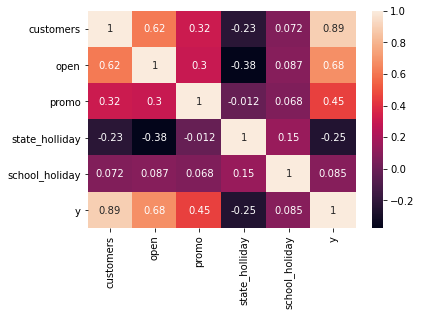

In [356]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [357]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

## Store 

In [358]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [359]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [360]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [361]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

## Features

In [362]:
# Rajouter la variable y/customers

train_df['SalesPerCustomers'] = train_df['y'] / train_df['customers']

avg_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store_df = pd.merge(avg_store.reset_index(), store_df, on='id')
store_df.head()

,id,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval
0,1,3950.539370,467.883202,8.397500,c,a,NaN
1,2,4117.196078,485.605229,8.408104,a,a,"Jan,Apr,Jul,Oct"
2,3,5850.149194,630.470430,9.138877,a,a,"Jan,Apr,Jul,Oct"
3,4,8028.679245,1102.529650,7.243965,c,c,NaN
4,5,3873.781291,445.283267,8.609952,a,a,NaN


In [363]:
# Rajout de la variable dayofweek et dayofyear
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df['day_of_week'] = pd.to_datetime(test_df['date']).dt.dayofweek

train_df['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df['day_of_year'] = pd.to_datetime(test_df['date']).dt.dayofyear

train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear

# okay = train_df.groupby(['id','day_of_week'])['y'].agg(['mean']).copy()
# train_df = pd.merge(left = train_df , right = okay.reset_index(), on=['id','day_of_week'], how ='left')
# test_df = pd.merge(left = test_df, right = okay.reset_index(),on=['id','day_of_week'], how ='left')

train_df.head()

<ipython-input-363-df9ea89b12cf>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
<ipython-input-363-df9ea89b12cf>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year
0,1042,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,NaN,1,1,1


In [364]:
#Ratio = y/customers byday_of_week
train_group = train_df.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio_by_day_of_week':train_group['y'].sum()/train_group['customers'].sum()})
customers_perday = pd.DataFrame({'CustomersPerDay':train_group['customers'].sum()})

train_df= pd.merge(left = train_df, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = ratio_df,on=['id','day_of_week'], how ='left')

train_df= pd.merge(left = train_df, right = customers_perday ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = customers_perday,on=['id','day_of_week'], how ='left')

#Rajout de app_y = ratio_by_dayofweek * customers
train_df['app_p'] = train_df['customers']*train_df['ratio_by_day_of_week']
test_df['app_p'] = test_df['customers']*test_df['ratio_by_day_of_week']

test_df

,id,date,customers,open,promo,state_holliday,school_holiday,y,day_of_week,day_of_year,week_of_year,ratio_by_day_of_week,CustomersPerDay,app_p
0,1105,2013-01-01,0,0,0,1,1,0,1,1,1,8.886458,53302,0.000000
1,306,2013-01-01,0,0,0,1,1,0,1,1,1,9.355798,42794,0.000000
2,1115,2013-01-01,0,0,0,1,1,0,1,1,1,14.573775,43355,0.000000
3,506,2013-01-01,0,0,0,1,1,0,1,1,1,9.022218,85560,0.000000
4,877,2013-01-01,0,0,0,1,1,0,1,1,1,7.372790,105188,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,4,212,31,11.468789,52610,6216.083748
203438,323,2015-07-31,716,1,1,0,1,0,4,212,31,11.870420,63891,8499.220673
203439,912,2015-07-31,806,1,1,0,1,0,4,212,31,7.555701,81229,6089.894644
203440,276,2015-07-31,575,1,1,0,1,0,4,212,31,7.808782,61537,4490.049482


In [365]:
# Remove points with 0 Sales
# Set Open = 0 when Sales = 0 OR Customers = 0
# train_df.loc[ (train_df['customers']==0) | (train_df['y']==0) , 'open' ] = 0
# train_df = train_df[train_df['open'] == 1]

In [366]:
pd.set_option('display.max_columns', None)

In [367]:
def build_features(train = train_df, store = store_df):
    # Convert string types into integers
    store['store_type'] = store['store_type'].astype('category').cat.codes
    store['assortment'] = store['assortment'].astype('category').cat.codes
    store['promo_interval'] = store['promo_interval'].astype('category').cat.codes
    train["state_holliday"] = train["state_holliday"].astype('category').cat.codes
    
    store['store_type'] = pd.to_numeric(store['store_type'])
    store['assortment'] = pd.to_numeric(store['assortment'])
    train['state_holliday'] = pd.to_numeric(train['state_holliday'])

    merged = pd.merge(train, store, on='id', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    #merged['day_of_week'] = pd.to_datetime(merged['date']).dt.dayofweek
    merged['Year'] = pd.to_datetime(merged['date']).dt.year
    merged['Month'] = pd.to_datetime(merged['date']).dt.month
    merged['Day'] = pd.to_datetime(merged['date']).dt.day
    merged['Week'] = pd.to_datetime(merged['date']).dt.week
    
    merged['Year'] = pd.to_numeric(merged['Year'])
    merged['Month'] = pd.to_numeric(merged['Month'])
    merged['Day'] = pd.to_numeric(merged['Day'])
    merged['Week'] = pd.to_numeric(merged['Week'])
    
    #merged = merged[merged['Month'] != 12] #Supprimer les valeurs du mois de Décembre

    return merged

med_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store_df = pd.merge(med_store.reset_index(), store_df, on='id')
features = build_features(train_df, store_df)
features

<ipython-input-367-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year,ratio_by_day_of_week,CustomersPerDay,app_p,Medy,Medcustomers,MedSalesPerCustomers,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval,Year,Month,Day,Week
0,1042,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,7.412280,62460,0.000000,3627.0,512.0,7.346963,3363.957839,446.072464,7.443203,0,0,0,2013,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,12.703947,64708,0.000000,6671.5,556.0,12.276435,6176.957143,492.961039,12.373707,3,2,1,2013,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,11.001093,31100,0.000000,4156.5,382.0,11.209468,3769.974832,334.003356,11.193422,3,2,1,2013,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,9.484903,57593,0.000000,4565.0,519.0,9.164230,4367.282993,467.165986,9.247951,3,0,-1,2013,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,10.635794,55098,0.000000,7030.0,691.0,10.433333,6343.254576,599.552413,10.508401,0,2,-1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,13.659357,4,212,31,11.625640,51739,7951.937919,5527.0,501.0,11.425388,5095.916777,439.859974,11.482440,0,2,-1,2015,7,31,31
813763,796,2015-07-31,769,1,1,0,1,8913,11.590377,4,212,31,10.584014,66834,8139.106862,6426.0,645.0,10.737490,5960.280702,548.217274,10.767563,0,2,-1,2015,7,31,31
813764,230,2015-07-31,1091,1,1,0,1,10988,10.071494,4,212,31,8.097225,101774,8834.072720,6948.0,896.0,7.904656,6305.500666,783.585885,7.973675,3,2,-1,2015,7,31,31
813765,387,2015-07-31,1402,1,1,0,1,14533,10.365906,4,212,31,7.753565,118376,10870.498006,7784.0,1094.0,7.587732,7561.992011,963.762983,7.727806,2,0,2,2015,7,31,31


In [368]:
#Remove outliers

# def reject_outliers(df,col_name, m=2.6):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# features = pd.concat([reject_outliers(df,'SalesPerCustomers') for ID,df in features.groupby(['id'])])
# features = features.sort_index()

# features

In [369]:
X = [
    'id', 
    'customers',
    'promo',
    'promo_interval',
    
    'school_holiday',
    'state_holliday',
    'store_type',
    'assortment',

    'Avgy',
    'Avgcustomers',
    'AvgSalesPerCustomers',
    
    'Medy',
    'Medcustomers',
    'MedSalesPerCustomers',

    'day_of_week',
    'day_of_year',
    'week_of_year',
    
    'Week',
    'Day',
    'Month',
    'Year',
    
    'ratio_by_day_of_week',
    'app_p',
    'CustomersPerDay',
]

X_train, X_valid, y_train, y_valid = train_test_split(
    features[X], features['y'], test_size=0.15, random_state=42)

X1 , y1 = features[X].copy(), features['y'].copy()

In [370]:
#Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

In [371]:
# Print input/target format 
print(f'Input shape  : {X1.shape}')
print(f'Target shape : {y1.shape}')
display(X1)

Input shape  : (813767, 24)
Target shape : (813767,)


,id,customers,promo,promo_interval,school_holiday,state_holliday,store_type,assortment,Avgy,Avgcustomers,AvgSalesPerCustomers,Medy,Medcustomers,MedSalesPerCustomers,day_of_week,day_of_year,week_of_year,Week,Day,Month,Year,ratio_by_day_of_week,app_p,CustomersPerDay
0,1042,0,0,0,1,1,0,0,3363.957839,446.072464,7.443203,3627.0,512.0,7.346963,1,1,1,1,1,1,2013,7.412280,0.000000,62460
1,128,0,0,1,1,1,3,2,6176.957143,492.961039,12.373707,6671.5,556.0,12.276435,1,1,1,1,1,1,2013,12.703947,0.000000,64708
2,420,0,0,1,1,1,3,2,3769.974832,334.003356,11.193422,4156.5,382.0,11.209468,1,1,1,1,1,1,2013,11.001093,0.000000,31100
3,225,0,0,-1,1,1,3,0,4367.282993,467.165986,9.247951,4565.0,519.0,9.164230,1,1,1,1,1,1,2013,9.484903,0.000000,57593
4,144,0,0,-1,1,1,0,2,6343.254576,599.552413,10.508401,7030.0,691.0,10.433333,1,1,1,1,1,1,2013,10.635794,0.000000,55098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,684,1,-1,1,0,0,2,5095.916777,439.859974,11.482440,5527.0,501.0,11.425388,4,212,31,31,31,7,2015,11.625640,7951.937919,51739
813763,796,769,1,-1,1,0,0,2,5960.280702,548.217274,10.767563,6426.0,645.0,10.737490,4,212,31,31,31,7,2015,10.584014,8139.106862,66834
813764,230,1091,1,-1,1,0,3,2,6305.500666,783.585885,7.973675,6948.0,896.0,7.904656,4,212,31,31,31,7,2015,8.097225,8834.072720,101774
813765,387,1402,1,2,1,0,2,0,7561.992011,963.762983,7.727806,7784.0,1094.0,7.587732,4,212,31,31,31,7,2015,7.753565,10870.498006,118376


In [372]:
# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 691701
Validation size : 122066


In [373]:
# Vérifier si X1 et test_df_new ne contient au final que des valeurs numériques

X1.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
# test_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                      True
customers               True
promo                   True
promo_interval          True
school_holiday          True
state_holliday          True
store_type              True
assortment              True
Avgy                    True
Avgcustomers            True
AvgSalesPerCustomers    True
Medy                    True
Medcustomers            True
MedSalesPerCustomers    True
day_of_week             True
day_of_year             True
week_of_year            True
Week                    True
Day                     True
Month                   True
Year                    True
ratio_by_day_of_week    True
app_p                   True
CustomersPerDay         True
dtype: bool

## Remove Outliers

In [374]:
# #remove outliers
# train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']
# def reject_outliers(df,col_name, m=1):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# train_nozero = pd.concat([reject_outliers(df,'ratio') for ID,df in train_nozero.groupby(['id'])])

In [330]:
# train_nozero = train_nozero.sort_index()
# train_nozero = train_nozero.drop(columns=['ratio'])

# test_df_new

# Train Models Pipeline

In [331]:
Models = dict()

In [ ]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    #train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(mae(y_train, train_preds))
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        
def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)
        

### Linear Regression

In [ ]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})


### Decision trees


In [ ]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(5,20,4)),'min_samples_leaf':range(1,20,2)
                                })

In [ ]:
model = Models['Decision Tree Regression']['model'].best_estimator_
plot_importance(model)

In [ ]:
train_model_grid_search(model_name = 'Ada Boost Decision Tree Regression',
                        model = AdaBoostRegressor(DecisionTreeRegressor(random_state = 42,max_depth=17,min_samples_leaf=13)),
                        grid = {})

### Random Forest

In [ ]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42, min_samples_leaf=9, max_depth=13),  grid={}
                        #grid = {'max_depth': range(10,100,30),
                        #        'min_samples_leaf':range(2,10,3),
                        #        'n_estimators': [100, 200, 300]}
                        )

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {#'n_neighbors':range(1,7),
                                #'weights':['uniform','distance'],
                                })

### XGBoost

In [ ]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(n_jobs = -1,
                                        n_estimators = 130,
                                        eta = 0.1,
                                        max_depth = 15,
                                        min_child_weight = 3,
                                        subsample = 0.8,
                                        colsample_bytree = 0.8,
                                        tree_method = 'exact',
                                        reg_alpha = 0.06,
                                        silent = 0,
                                        random_state = 1043),
                        grid = {'max_depth': range(15,23,2)})

In [ ]:
model = Models['XGBoost']['model'].best_estimator_
plot_importance(model)

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

In [ ]:
# Separating the features and the target
X, y = train_df_new.drop(columns=['y', 'id']), train_df_new['y']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}\n')
print(f'Target : \n{y}')

In [ ]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = scaler.transform(test_df_new.drop(columns=['y', 'id']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

In [ ]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

In [ ]:
# Training params
nb_epochs = 50
model_hist = model.fit(x=X_train, y=y_train, validation_data=(X_valid,y_valid), batch_size=32, epochs=nb_epochs, verbose=1).history

In [ ]:
##Prediction
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
Models['Neural Network'] = {'model':model,
                             'scores':{'train':mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)}}
print("   -   MAE on the train set : {:.2f}".format(Models['Neural Network']['scores']['train']))
print("   -   MAE on the test set : {:.2f}".format(Models['Neural Network']['scores']['valid']))

# Approch Results

In [ ]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

# MODELS - trained on both train and valid set

## XGBoost

In [54]:
xgb = XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)

In [56]:
xgb.fit(X1, y1,eval_metric = 'mae')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=17,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=8, num_parallel_tree=1, random_state=1043,
             reg_alpha=0.06, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
features = build_features(test_df, store_df)

test_preds = xgb.predict(features[X])

test_preds

<ipython-input-30-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([-9.3204504e-01,  9.3263578e+00, -1.6128497e+00, ...,
        7.1802192e+03,  4.9872017e+03,  6.9661904e+03], dtype=float32)

In [55]:
xgb.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

[0]	validation_0-mae:5197.66064	validation_1-mae:5192.37842
[1]	validation_0-mae:4678.66064	validation_1-mae:4674.17529
[2]	validation_0-mae:4211.57861	validation_1-mae:4207.54932
[3]	validation_0-mae:3800.60815	validation_1-mae:3797.56934
[4]	validation_0-mae:3420.91333	validation_1-mae:3418.21484
[5]	validation_0-mae:3079.25171	validation_1-mae:3076.90063
[6]	validation_0-mae:2772.06909	validation_1-mae:2770.02832
[7]	validation_0-mae:2495.35352	validation_1-mae:2493.59692
[8]	validation_0-mae:2246.45068	validation_1-mae:2244.90479
[9]	validation_0-mae:2022.42432	validation_1-mae:2021.14893
[10]	validation_0-mae:1820.69665	validation_1-mae:1819.54028
[11]	validation_0-mae:1639.15039	validation_1-mae:1638.21301
[12]	validation_0-mae:1475.74206	validation_1-mae:1474.95312
[13]	validation_0-mae:1328.70996	validation_1-mae:1328.08118
[14]	validation_0-mae:1196.45129	validation_1-mae:1195.98657
[15]	validation_0-mae:1077.61865	validation_1-mae:1077.33936
[16]	validation_0-mae:970.62848	va

[138]	validation_0-mae:122.44317	validation_1-mae:215.08423
[139]	validation_0-mae:122.05223	validation_1-mae:215.09909


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=17,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=8, num_parallel_tree=1, random_state=1043,
             reg_alpha=0.06, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
from sklearn import model_selection
def evaluate_model(model, X, y):
    cv = model_selection.KFold(n_splits=5)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, error_score='raise',verbose=1)
    return scores

In [42]:
evaluate_model(xgb,X1,y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.0min finished


array([-243.18998961, -265.83206034, -234.66603718, -252.04257656,
       -282.7151959 ])

## Random Forest

In [143]:
rdmForest = RandomForestRegressor(n_estimators=300, max_depth=17, n_jobs=-1, random_state=1043)

rdmForest.fit(X1,y1)

RandomForestRegressor(max_depth=17, n_estimators=300, n_jobs=-1,
                      random_state=1043)

In [144]:
features = build_features(test_df, store_df)

test_preds = rdmForest.predict(features[X])

test_preds

<ipython-input-135-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([   0.        ,    0.        ,    0.        , ..., 6884.79827785,
       5145.19432829, 7031.25198579])

In [48]:
mae(y1,model.predict(X1))

121.79383110328251

## Decision Tree Regressor

In [ ]:
desision_tree = DecisionTreeRegressor(splitter='random', max_depth=16, random_state=21)

desision_tree.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = desision_tree.predict(features[X])

test_preds

## LightGBM

In [379]:
import lightgbm as lgb
base_lgb_model = lgb.LGBMRegressor(num_leaves=65,
                               n_estimators=4000, 
                               max_depth=15,  
                               min_child_weight=0.008,
                               learning_rate=0.1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=1,
                               min_child_samples=20
                                )



In [380]:
base_lgb_model.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 100
                )

[1]	valid_0's l1: 2612.45	valid_0's l2: 1.21347e+07	valid_1's l1: 2607.05	valid_1's l2: 1.21009e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 2356.85	valid_0's l2: 9.88151e+06	valid_1's l1: 2352.32	valid_1's l2: 9.85609e+06
[3]	valid_0's l1: 2151.17	valid_0's l2: 8.23809e+06	valid_1's l1: 2147.59	valid_1's l2: 8.21967e+06
[4]	valid_0's l1: 1943.04	valid_0's l2: 6.72489e+06	valid_1's l1: 1940.08	valid_1's l2: 6.71172e+06
[5]	valid_0's l1: 1761.47	valid_0's l2: 5.53081e+06	valid_1's l1: 1759.05	valid_1's l2: 5.52223e+06
[6]	valid_0's l1: 1594.1	valid_0's l2: 4.53104e+06	valid_1's l1: 1592.27	valid_1's l2: 4.52587e+06
[7]	valid_0's l1: 1443.44	valid_0's l2: 3.71891e+06	valid_1's l1: 1442.13	valid_1's l2: 3.7172e+06
[8]	valid_0's l1: 1312.44	valid_0's l2: 3.08042e+06	valid_1's l1: 1311.62	valid_1's l2: 3.0811e+06
[9]	valid_0's l1: 1219.16	valid_0's l2: 2.64475e+06	valid_1's l1: 1218.75	valid_1's l2: 2.64689e+06
[10]	valid_0's l1: 1108.33	valid_0's l2: 

[90]	valid_0's l1: 235.808	valid_0's l2: 135501	valid_1's l1: 238.709	valid_1's l2: 145343
[91]	valid_0's l1: 235.63	valid_0's l2: 135166	valid_1's l1: 238.551	valid_1's l2: 145037
[92]	valid_0's l1: 235.409	valid_0's l2: 134922	valid_1's l1: 238.353	valid_1's l2: 144798
[93]	valid_0's l1: 235.161	valid_0's l2: 134613	valid_1's l1: 238.102	valid_1's l2: 144514
[94]	valid_0's l1: 234.972	valid_0's l2: 134377	valid_1's l1: 237.923	valid_1's l2: 144294
[95]	valid_0's l1: 234.84	valid_0's l2: 133996	valid_1's l1: 237.796	valid_1's l2: 143885
[96]	valid_0's l1: 234.65	valid_0's l2: 133723	valid_1's l1: 237.615	valid_1's l2: 143600
[97]	valid_0's l1: 234.548	valid_0's l2: 133518	valid_1's l1: 237.554	valid_1's l2: 143454
[98]	valid_0's l1: 234.381	valid_0's l2: 133305	valid_1's l1: 237.418	valid_1's l2: 143302
[99]	valid_0's l1: 234.298	valid_0's l2: 133086	valid_1's l1: 237.366	valid_1's l2: 143178
[100]	valid_0's l1: 234.144	valid_0's l2: 132882	valid_1's l1: 237.21	valid_1's l2: 142995
[1

[181]	valid_0's l1: 226.255	valid_0's l2: 120760	valid_1's l1: 230.648	valid_1's l2: 133430
[182]	valid_0's l1: 226.232	valid_0's l2: 120684	valid_1's l1: 230.645	valid_1's l2: 133389
[183]	valid_0's l1: 226.177	valid_0's l2: 120604	valid_1's l1: 230.597	valid_1's l2: 133348
[184]	valid_0's l1: 226.138	valid_0's l2: 120522	valid_1's l1: 230.571	valid_1's l2: 133278
[185]	valid_0's l1: 226.082	valid_0's l2: 120436	valid_1's l1: 230.544	valid_1's l2: 133249
[186]	valid_0's l1: 225.96	valid_0's l2: 120306	valid_1's l1: 230.442	valid_1's l2: 133147
[187]	valid_0's l1: 225.937	valid_0's l2: 120232	valid_1's l1: 230.438	valid_1's l2: 133125
[188]	valid_0's l1: 225.881	valid_0's l2: 120156	valid_1's l1: 230.398	valid_1's l2: 133090
[189]	valid_0's l1: 225.812	valid_0's l2: 120077	valid_1's l1: 230.341	valid_1's l2: 133039
[190]	valid_0's l1: 225.74	valid_0's l2: 119965	valid_1's l1: 230.291	valid_1's l2: 132964
[191]	valid_0's l1: 225.649	valid_0's l2: 119900	valid_1's l1: 230.211	valid_1's l

[271]	valid_0's l1: 221.325	valid_0's l2: 113880	valid_1's l1: 227.034	valid_1's l2: 128608
[272]	valid_0's l1: 221.309	valid_0's l2: 113835	valid_1's l1: 227.023	valid_1's l2: 128575
[273]	valid_0's l1: 221.239	valid_0's l2: 113759	valid_1's l1: 226.968	valid_1's l2: 128519
[274]	valid_0's l1: 221.194	valid_0's l2: 113695	valid_1's l1: 226.94	valid_1's l2: 128475
[275]	valid_0's l1: 221.168	valid_0's l2: 113668	valid_1's l1: 226.927	valid_1's l2: 128462
[276]	valid_0's l1: 221.106	valid_0's l2: 113581	valid_1's l1: 226.875	valid_1's l2: 128384
[277]	valid_0's l1: 221.052	valid_0's l2: 113510	valid_1's l1: 226.84	valid_1's l2: 128323
[278]	valid_0's l1: 221.012	valid_0's l2: 113448	valid_1's l1: 226.817	valid_1's l2: 128285
[279]	valid_0's l1: 220.963	valid_0's l2: 113384	valid_1's l1: 226.787	valid_1's l2: 128241
[280]	valid_0's l1: 220.889	valid_0's l2: 113307	valid_1's l1: 226.716	valid_1's l2: 128161
[281]	valid_0's l1: 220.852	valid_0's l2: 113258	valid_1's l1: 226.706	valid_1's l

[365]	valid_0's l1: 217.209	valid_0's l2: 108521	valid_1's l1: 224.151	valid_1's l2: 124922
[366]	valid_0's l1: 217.144	valid_0's l2: 108457	valid_1's l1: 224.115	valid_1's l2: 124891
[367]	valid_0's l1: 217.113	valid_0's l2: 108413	valid_1's l1: 224.092	valid_1's l2: 124883
[368]	valid_0's l1: 217.1	valid_0's l2: 108384	valid_1's l1: 224.091	valid_1's l2: 124880
[369]	valid_0's l1: 217.062	valid_0's l2: 108339	valid_1's l1: 224.068	valid_1's l2: 124863
[370]	valid_0's l1: 217.034	valid_0's l2: 108309	valid_1's l1: 224.049	valid_1's l2: 124851
[371]	valid_0's l1: 217.003	valid_0's l2: 108269	valid_1's l1: 224.027	valid_1's l2: 124823
[372]	valid_0's l1: 216.983	valid_0's l2: 108233	valid_1's l1: 224.019	valid_1's l2: 124806
[373]	valid_0's l1: 216.972	valid_0's l2: 108212	valid_1's l1: 224.016	valid_1's l2: 124800
[374]	valid_0's l1: 216.939	valid_0's l2: 108164	valid_1's l1: 223.996	valid_1's l2: 124775
[375]	valid_0's l1: 216.896	valid_0's l2: 108105	valid_1's l1: 223.964	valid_1's l

[459]	valid_0's l1: 213.869	valid_0's l2: 104119	valid_1's l1: 221.96	valid_1's l2: 122379
[460]	valid_0's l1: 213.85	valid_0's l2: 104086	valid_1's l1: 221.959	valid_1's l2: 122366
[461]	valid_0's l1: 213.838	valid_0's l2: 104060	valid_1's l1: 221.951	valid_1's l2: 122366
[462]	valid_0's l1: 213.813	valid_0's l2: 104032	valid_1's l1: 221.944	valid_1's l2: 122361
[463]	valid_0's l1: 213.789	valid_0's l2: 104003	valid_1's l1: 221.934	valid_1's l2: 122356
[464]	valid_0's l1: 213.78	valid_0's l2: 103981	valid_1's l1: 221.939	valid_1's l2: 122361
[465]	valid_0's l1: 213.751	valid_0's l2: 103952	valid_1's l1: 221.919	valid_1's l2: 122346
[466]	valid_0's l1: 213.71	valid_0's l2: 103898	valid_1's l1: 221.89	valid_1's l2: 122287
[467]	valid_0's l1: 213.694	valid_0's l2: 103871	valid_1's l1: 221.888	valid_1's l2: 122284
[468]	valid_0's l1: 213.681	valid_0's l2: 103846	valid_1's l1: 221.89	valid_1's l2: 122282
[469]	valid_0's l1: 213.652	valid_0's l2: 103812	valid_1's l1: 221.875	valid_1's l2: 1

[551]	valid_0's l1: 211.359	valid_0's l2: 101150	valid_1's l1: 220.579	valid_1's l2: 120775
[552]	valid_0's l1: 211.327	valid_0's l2: 101092	valid_1's l1: 220.564	valid_1's l2: 120764
[553]	valid_0's l1: 211.285	valid_0's l2: 101040	valid_1's l1: 220.54	valid_1's l2: 120734
[554]	valid_0's l1: 211.248	valid_0's l2: 101001	valid_1's l1: 220.524	valid_1's l2: 120726
[555]	valid_0's l1: 211.194	valid_0's l2: 100953	valid_1's l1: 220.479	valid_1's l2: 120686
[556]	valid_0's l1: 211.155	valid_0's l2: 100912	valid_1's l1: 220.456	valid_1's l2: 120663
[557]	valid_0's l1: 211.109	valid_0's l2: 100858	valid_1's l1: 220.427	valid_1's l2: 120630
[558]	valid_0's l1: 211.072	valid_0's l2: 100817	valid_1's l1: 220.402	valid_1's l2: 120606
[559]	valid_0's l1: 211.022	valid_0's l2: 100769	valid_1's l1: 220.369	valid_1's l2: 120576
[560]	valid_0's l1: 211.009	valid_0's l2: 100746	valid_1's l1: 220.364	valid_1's l2: 120571
[561]	valid_0's l1: 210.98	valid_0's l2: 100718	valid_1's l1: 220.348	valid_1's l

[641]	valid_0's l1: 208.879	valid_0's l2: 98177.6	valid_1's l1: 219.154	valid_1's l2: 119205
[642]	valid_0's l1: 208.846	valid_0's l2: 98141	valid_1's l1: 219.137	valid_1's l2: 119172
[643]	valid_0's l1: 208.82	valid_0's l2: 98109	valid_1's l1: 219.123	valid_1's l2: 119165
[644]	valid_0's l1: 208.781	valid_0's l2: 98064.2	valid_1's l1: 219.091	valid_1's l2: 119124
[645]	valid_0's l1: 208.739	valid_0's l2: 98027.6	valid_1's l1: 219.06	valid_1's l2: 119097
[646]	valid_0's l1: 208.712	valid_0's l2: 97992.1	valid_1's l1: 219.047	valid_1's l2: 119080
[647]	valid_0's l1: 208.7	valid_0's l2: 97982.1	valid_1's l1: 219.042	valid_1's l2: 119075
[648]	valid_0's l1: 208.677	valid_0's l2: 97946.3	valid_1's l1: 219.032	valid_1's l2: 119054
[649]	valid_0's l1: 208.638	valid_0's l2: 97898.3	valid_1's l1: 218.991	valid_1's l2: 118995
[650]	valid_0's l1: 208.607	valid_0's l2: 97852.2	valid_1's l1: 218.976	valid_1's l2: 119019
[651]	valid_0's l1: 208.589	valid_0's l2: 97837.8	valid_1's l1: 218.975	valid_

[731]	valid_0's l1: 206.853	valid_0's l2: 95779.9	valid_1's l1: 218.15	valid_1's l2: 117944
[732]	valid_0's l1: 206.812	valid_0's l2: 95760.3	valid_1's l1: 218.12	valid_1's l2: 117933
[733]	valid_0's l1: 206.78	valid_0's l2: 95732.6	valid_1's l1: 218.098	valid_1's l2: 117910
[734]	valid_0's l1: 206.773	valid_0's l2: 95719.9	valid_1's l1: 218.095	valid_1's l2: 117904
[735]	valid_0's l1: 206.762	valid_0's l2: 95704.6	valid_1's l1: 218.095	valid_1's l2: 117901
[736]	valid_0's l1: 206.736	valid_0's l2: 95687.8	valid_1's l1: 218.077	valid_1's l2: 117888
[737]	valid_0's l1: 206.714	valid_0's l2: 95651	valid_1's l1: 218.077	valid_1's l2: 117874
[738]	valid_0's l1: 206.691	valid_0's l2: 95636.1	valid_1's l1: 218.065	valid_1's l2: 117871
[739]	valid_0's l1: 206.665	valid_0's l2: 95611.5	valid_1's l1: 218.05	valid_1's l2: 117852
[740]	valid_0's l1: 206.642	valid_0's l2: 95585.5	valid_1's l1: 218.039	valid_1's l2: 117841
[741]	valid_0's l1: 206.622	valid_0's l2: 95539.4	valid_1's l1: 218.017	vali

[820]	valid_0's l1: 204.778	valid_0's l2: 93458.4	valid_1's l1: 217.131	valid_1's l2: 116825
[821]	valid_0's l1: 204.752	valid_0's l2: 93430.9	valid_1's l1: 217.113	valid_1's l2: 116804
[822]	valid_0's l1: 204.714	valid_0's l2: 93392.5	valid_1's l1: 217.083	valid_1's l2: 116761
[823]	valid_0's l1: 204.707	valid_0's l2: 93378.9	valid_1's l1: 217.082	valid_1's l2: 116760
[824]	valid_0's l1: 204.685	valid_0's l2: 93359	valid_1's l1: 217.076	valid_1's l2: 116757
[825]	valid_0's l1: 204.663	valid_0's l2: 93331.2	valid_1's l1: 217.061	valid_1's l2: 116742
[826]	valid_0's l1: 204.649	valid_0's l2: 93312.8	valid_1's l1: 217.053	valid_1's l2: 116737
[827]	valid_0's l1: 204.613	valid_0's l2: 93281.2	valid_1's l1: 217.021	valid_1's l2: 116708
[828]	valid_0's l1: 204.594	valid_0's l2: 93261.9	valid_1's l1: 217.016	valid_1's l2: 116701
[829]	valid_0's l1: 204.56	valid_0's l2: 93230	valid_1's l1: 216.991	valid_1's l2: 116681
[830]	valid_0's l1: 204.536	valid_0's l2: 93185.6	valid_1's l1: 216.985	val

[912]	valid_0's l1: 202.966	valid_0's l2: 91364.3	valid_1's l1: 216.436	valid_1's l2: 115925
[913]	valid_0's l1: 202.949	valid_0's l2: 91348.1	valid_1's l1: 216.428	valid_1's l2: 115914
[914]	valid_0's l1: 202.929	valid_0's l2: 91330.5	valid_1's l1: 216.421	valid_1's l2: 115908
[915]	valid_0's l1: 202.908	valid_0's l2: 91305	valid_1's l1: 216.413	valid_1's l2: 115898
[916]	valid_0's l1: 202.882	valid_0's l2: 91286.4	valid_1's l1: 216.4	valid_1's l2: 115890
[917]	valid_0's l1: 202.864	valid_0's l2: 91260.8	valid_1's l1: 216.389	valid_1's l2: 115886
[918]	valid_0's l1: 202.838	valid_0's l2: 91238.2	valid_1's l1: 216.378	valid_1's l2: 115874
[919]	valid_0's l1: 202.819	valid_0's l2: 91217.3	valid_1's l1: 216.367	valid_1's l2: 115862
[920]	valid_0's l1: 202.81	valid_0's l2: 91201.5	valid_1's l1: 216.369	valid_1's l2: 115869
[921]	valid_0's l1: 202.79	valid_0's l2: 91184.7	valid_1's l1: 216.36	valid_1's l2: 115866
[922]	valid_0's l1: 202.766	valid_0's l2: 91154.3	valid_1's l1: 216.343	valid

[1004]	valid_0's l1: 201.322	valid_0's l2: 89587.6	valid_1's l1: 215.834	valid_1's l2: 115309
[1005]	valid_0's l1: 201.313	valid_0's l2: 89573	valid_1's l1: 215.83	valid_1's l2: 115301
[1006]	valid_0's l1: 201.306	valid_0's l2: 89561.6	valid_1's l1: 215.828	valid_1's l2: 115298
[1007]	valid_0's l1: 201.284	valid_0's l2: 89543.2	valid_1's l1: 215.821	valid_1's l2: 115293
[1008]	valid_0's l1: 201.268	valid_0's l2: 89520.9	valid_1's l1: 215.82	valid_1's l2: 115291
[1009]	valid_0's l1: 201.249	valid_0's l2: 89501	valid_1's l1: 215.814	valid_1's l2: 115286
[1010]	valid_0's l1: 201.231	valid_0's l2: 89484.4	valid_1's l1: 215.812	valid_1's l2: 115283
[1011]	valid_0's l1: 201.215	valid_0's l2: 89457.5	valid_1's l1: 215.808	valid_1's l2: 115280
[1012]	valid_0's l1: 201.202	valid_0's l2: 89441.8	valid_1's l1: 215.804	valid_1's l2: 115281
[1013]	valid_0's l1: 201.18	valid_0's l2: 89420.5	valid_1's l1: 215.799	valid_1's l2: 115274
[1014]	valid_0's l1: 201.159	valid_0's l2: 89399.5	valid_1's l1: 21

[1092]	valid_0's l1: 199.828	valid_0's l2: 88032.6	valid_1's l1: 215.308	valid_1's l2: 114708
[1093]	valid_0's l1: 199.811	valid_0's l2: 88016.2	valid_1's l1: 215.309	valid_1's l2: 114705
[1094]	valid_0's l1: 199.782	valid_0's l2: 87996.8	valid_1's l1: 215.285	valid_1's l2: 114691
[1095]	valid_0's l1: 199.765	valid_0's l2: 87974.5	valid_1's l1: 215.289	valid_1's l2: 114690
[1096]	valid_0's l1: 199.749	valid_0's l2: 87961.8	valid_1's l1: 215.289	valid_1's l2: 114695
[1097]	valid_0's l1: 199.734	valid_0's l2: 87943.7	valid_1's l1: 215.292	valid_1's l2: 114696
[1098]	valid_0's l1: 199.721	valid_0's l2: 87929.5	valid_1's l1: 215.294	valid_1's l2: 114698
[1099]	valid_0's l1: 199.714	valid_0's l2: 87919.7	valid_1's l1: 215.296	valid_1's l2: 114699
[1100]	valid_0's l1: 199.7	valid_0's l2: 87906.6	valid_1's l1: 215.293	valid_1's l2: 114696
[1101]	valid_0's l1: 199.695	valid_0's l2: 87897.5	valid_1's l1: 215.294	valid_1's l2: 114696
[1102]	valid_0's l1: 199.665	valid_0's l2: 87868.7	valid_1's l

[1183]	valid_0's l1: 198.197	valid_0's l2: 86280.6	valid_1's l1: 214.668	valid_1's l2: 113998
[1184]	valid_0's l1: 198.182	valid_0's l2: 86269.8	valid_1's l1: 214.661	valid_1's l2: 113998
[1185]	valid_0's l1: 198.17	valid_0's l2: 86256.1	valid_1's l1: 214.659	valid_1's l2: 113992
[1186]	valid_0's l1: 198.153	valid_0's l2: 86238.7	valid_1's l1: 214.658	valid_1's l2: 113988
[1187]	valid_0's l1: 198.14	valid_0's l2: 86227.5	valid_1's l1: 214.655	valid_1's l2: 113983
[1188]	valid_0's l1: 198.125	valid_0's l2: 86211.4	valid_1's l1: 214.643	valid_1's l2: 113971
[1189]	valid_0's l1: 198.104	valid_0's l2: 86189.7	valid_1's l1: 214.63	valid_1's l2: 113958
[1190]	valid_0's l1: 198.078	valid_0's l2: 86168.2	valid_1's l1: 214.614	valid_1's l2: 113943
[1191]	valid_0's l1: 198.056	valid_0's l2: 86147.2	valid_1's l1: 214.608	valid_1's l2: 113936
[1192]	valid_0's l1: 198.04	valid_0's l2: 86135.7	valid_1's l1: 214.606	valid_1's l2: 113934
[1193]	valid_0's l1: 198.034	valid_0's l2: 86125.9	valid_1's l1:

[1270]	valid_0's l1: 196.77	valid_0's l2: 84811.8	valid_1's l1: 214.159	valid_1's l2: 113295
[1271]	valid_0's l1: 196.75	valid_0's l2: 84793	valid_1's l1: 214.149	valid_1's l2: 113284
[1272]	valid_0's l1: 196.712	valid_0's l2: 84762	valid_1's l1: 214.126	valid_1's l2: 113266
[1273]	valid_0's l1: 196.694	valid_0's l2: 84746.7	valid_1's l1: 214.122	valid_1's l2: 113261
[1274]	valid_0's l1: 196.675	valid_0's l2: 84727.3	valid_1's l1: 214.113	valid_1's l2: 113255
[1275]	valid_0's l1: 196.654	valid_0's l2: 84705.2	valid_1's l1: 214.105	valid_1's l2: 113237
[1276]	valid_0's l1: 196.639	valid_0's l2: 84691.8	valid_1's l1: 214.107	valid_1's l2: 113235
[1277]	valid_0's l1: 196.632	valid_0's l2: 84682	valid_1's l1: 214.106	valid_1's l2: 113231
[1278]	valid_0's l1: 196.621	valid_0's l2: 84669.8	valid_1's l1: 214.103	valid_1's l2: 113230
[1279]	valid_0's l1: 196.596	valid_0's l2: 84648.1	valid_1's l1: 214.087	valid_1's l2: 113216
[1280]	valid_0's l1: 196.591	valid_0's l2: 84640	valid_1's l1: 214.0

[1360]	valid_0's l1: 195.326	valid_0's l2: 83384.7	valid_1's l1: 213.62	valid_1's l2: 112822
[1361]	valid_0's l1: 195.307	valid_0's l2: 83369.4	valid_1's l1: 213.614	valid_1's l2: 112819
[1362]	valid_0's l1: 195.288	valid_0's l2: 83350.4	valid_1's l1: 213.609	valid_1's l2: 112813
[1363]	valid_0's l1: 195.268	valid_0's l2: 83335.1	valid_1's l1: 213.598	valid_1's l2: 112808
[1364]	valid_0's l1: 195.248	valid_0's l2: 83305	valid_1's l1: 213.593	valid_1's l2: 112815
[1365]	valid_0's l1: 195.233	valid_0's l2: 83289.8	valid_1's l1: 213.586	valid_1's l2: 112801
[1366]	valid_0's l1: 195.219	valid_0's l2: 83278.1	valid_1's l1: 213.585	valid_1's l2: 112801
[1367]	valid_0's l1: 195.203	valid_0's l2: 83270.5	valid_1's l1: 213.577	valid_1's l2: 112799
[1368]	valid_0's l1: 195.193	valid_0's l2: 83261.1	valid_1's l1: 213.574	valid_1's l2: 112795
[1369]	valid_0's l1: 195.181	valid_0's l2: 83251.6	valid_1's l1: 213.574	valid_1's l2: 112797
[1370]	valid_0's l1: 195.169	valid_0's l2: 83237.4	valid_1's l1

[1450]	valid_0's l1: 194.102	valid_0's l2: 82189.2	valid_1's l1: 213.269	valid_1's l2: 112494
[1451]	valid_0's l1: 194.087	valid_0's l2: 82173.5	valid_1's l1: 213.272	valid_1's l2: 112494
[1452]	valid_0's l1: 194.082	valid_0's l2: 82166.3	valid_1's l1: 213.271	valid_1's l2: 112499
[1453]	valid_0's l1: 194.067	valid_0's l2: 82152.7	valid_1's l1: 213.271	valid_1's l2: 112498
[1454]	valid_0's l1: 194.053	valid_0's l2: 82138.1	valid_1's l1: 213.265	valid_1's l2: 112495
[1455]	valid_0's l1: 194.04	valid_0's l2: 82124.9	valid_1's l1: 213.263	valid_1's l2: 112490
[1456]	valid_0's l1: 194.028	valid_0's l2: 82111.5	valid_1's l1: 213.258	valid_1's l2: 112489
[1457]	valid_0's l1: 194.013	valid_0's l2: 82101.1	valid_1's l1: 213.248	valid_1's l2: 112483
[1458]	valid_0's l1: 194.001	valid_0's l2: 82090.1	valid_1's l1: 213.248	valid_1's l2: 112479
[1459]	valid_0's l1: 193.988	valid_0's l2: 82081.4	valid_1's l1: 213.242	valid_1's l2: 112474
[1460]	valid_0's l1: 193.955	valid_0's l2: 82048.9	valid_1's 

[1537]	valid_0's l1: 192.799	valid_0's l2: 80928.1	valid_1's l1: 212.875	valid_1's l2: 112067
[1538]	valid_0's l1: 192.783	valid_0's l2: 80913.7	valid_1's l1: 212.87	valid_1's l2: 112062
[1539]	valid_0's l1: 192.77	valid_0's l2: 80903.4	valid_1's l1: 212.864	valid_1's l2: 112059
[1540]	valid_0's l1: 192.756	valid_0's l2: 80888.4	valid_1's l1: 212.864	valid_1's l2: 112055
[1541]	valid_0's l1: 192.741	valid_0's l2: 80875	valid_1's l1: 212.863	valid_1's l2: 112055
[1542]	valid_0's l1: 192.731	valid_0's l2: 80863.8	valid_1's l1: 212.864	valid_1's l2: 112053
[1543]	valid_0's l1: 192.719	valid_0's l2: 80849.9	valid_1's l1: 212.861	valid_1's l2: 112048
[1544]	valid_0's l1: 192.713	valid_0's l2: 80846.2	valid_1's l1: 212.859	valid_1's l2: 112047
[1545]	valid_0's l1: 192.702	valid_0's l2: 80834.1	valid_1's l1: 212.858	valid_1's l2: 112047
[1546]	valid_0's l1: 192.693	valid_0's l2: 80823.6	valid_1's l1: 212.856	valid_1's l2: 112037
[1547]	valid_0's l1: 192.689	valid_0's l2: 80817.6	valid_1's l1:

[1628]	valid_0's l1: 191.564	valid_0's l2: 79639.9	valid_1's l1: 212.534	valid_1's l2: 111683
[1629]	valid_0's l1: 191.541	valid_0's l2: 79621.3	valid_1's l1: 212.519	valid_1's l2: 111669
[1630]	valid_0's l1: 191.529	valid_0's l2: 79611.4	valid_1's l1: 212.517	valid_1's l2: 111667
[1631]	valid_0's l1: 191.514	valid_0's l2: 79550.2	valid_1's l1: 212.519	valid_1's l2: 111667
[1632]	valid_0's l1: 191.502	valid_0's l2: 79535.5	valid_1's l1: 212.517	valid_1's l2: 111666
[1633]	valid_0's l1: 191.489	valid_0's l2: 79525.3	valid_1's l1: 212.511	valid_1's l2: 111662
[1634]	valid_0's l1: 191.477	valid_0's l2: 79514.9	valid_1's l1: 212.508	valid_1's l2: 111658
[1635]	valid_0's l1: 191.46	valid_0's l2: 79499.1	valid_1's l1: 212.501	valid_1's l2: 111650
[1636]	valid_0's l1: 191.453	valid_0's l2: 79493.1	valid_1's l1: 212.501	valid_1's l2: 111651
[1637]	valid_0's l1: 191.44	valid_0's l2: 79479.3	valid_1's l1: 212.507	valid_1's l2: 111655
[1638]	valid_0's l1: 191.424	valid_0's l2: 79465.9	valid_1's l

[1717]	valid_0's l1: 190.473	valid_0's l2: 78539.4	valid_1's l1: 212.322	valid_1's l2: 111399
[1718]	valid_0's l1: 190.448	valid_0's l2: 78519.8	valid_1's l1: 212.309	valid_1's l2: 111382
[1719]	valid_0's l1: 190.436	valid_0's l2: 78510.3	valid_1's l1: 212.31	valid_1's l2: 111381
[1720]	valid_0's l1: 190.421	valid_0's l2: 78494.3	valid_1's l1: 212.306	valid_1's l2: 111377
[1721]	valid_0's l1: 190.409	valid_0's l2: 78483.5	valid_1's l1: 212.299	valid_1's l2: 111372
[1722]	valid_0's l1: 190.398	valid_0's l2: 78474.3	valid_1's l1: 212.302	valid_1's l2: 111373
[1723]	valid_0's l1: 190.386	valid_0's l2: 78462.8	valid_1's l1: 212.299	valid_1's l2: 111368
[1724]	valid_0's l1: 190.371	valid_0's l2: 78445.4	valid_1's l1: 212.297	valid_1's l2: 111363
[1725]	valid_0's l1: 190.361	valid_0's l2: 78434.6	valid_1's l1: 212.296	valid_1's l2: 111369
[1726]	valid_0's l1: 190.347	valid_0's l2: 78421.8	valid_1's l1: 212.294	valid_1's l2: 111367
[1727]	valid_0's l1: 190.331	valid_0's l2: 78405.1	valid_1's 

[1810]	valid_0's l1: 189.397	valid_0's l2: 77500.1	valid_1's l1: 212.091	valid_1's l2: 111162
[1811]	valid_0's l1: 189.372	valid_0's l2: 77478.4	valid_1's l1: 212.074	valid_1's l2: 111141
[1812]	valid_0's l1: 189.357	valid_0's l2: 77463.1	valid_1's l1: 212.068	valid_1's l2: 111133
[1813]	valid_0's l1: 189.348	valid_0's l2: 77455	valid_1's l1: 212.067	valid_1's l2: 111133
[1814]	valid_0's l1: 189.331	valid_0's l2: 77439.4	valid_1's l1: 212.063	valid_1's l2: 111130
[1815]	valid_0's l1: 189.318	valid_0's l2: 77426	valid_1's l1: 212.061	valid_1's l2: 111128
[1816]	valid_0's l1: 189.305	valid_0's l2: 77407.1	valid_1's l1: 212.058	valid_1's l2: 111125
[1817]	valid_0's l1: 189.292	valid_0's l2: 77391.9	valid_1's l1: 212.059	valid_1's l2: 111124
[1818]	valid_0's l1: 189.278	valid_0's l2: 77380.7	valid_1's l1: 212.057	valid_1's l2: 111122
[1819]	valid_0's l1: 189.272	valid_0's l2: 77377.1	valid_1's l1: 212.057	valid_1's l2: 111122
[1820]	valid_0's l1: 189.262	valid_0's l2: 77365.6	valid_1's l1:

[1898]	valid_0's l1: 188.249	valid_0's l2: 76414.2	valid_1's l1: 211.796	valid_1's l2: 110859
[1899]	valid_0's l1: 188.239	valid_0's l2: 76405.8	valid_1's l1: 211.794	valid_1's l2: 110856
[1900]	valid_0's l1: 188.228	valid_0's l2: 76395.1	valid_1's l1: 211.798	valid_1's l2: 110858
[1901]	valid_0's l1: 188.216	valid_0's l2: 76380.9	valid_1's l1: 211.797	valid_1's l2: 110846
[1902]	valid_0's l1: 188.203	valid_0's l2: 76364.3	valid_1's l1: 211.797	valid_1's l2: 110842
[1903]	valid_0's l1: 188.192	valid_0's l2: 76353.7	valid_1's l1: 211.795	valid_1's l2: 110839
[1904]	valid_0's l1: 188.184	valid_0's l2: 76346.6	valid_1's l1: 211.791	valid_1's l2: 110839
[1905]	valid_0's l1: 188.17	valid_0's l2: 76334.5	valid_1's l1: 211.794	valid_1's l2: 110839
[1906]	valid_0's l1: 188.161	valid_0's l2: 76325.5	valid_1's l1: 211.791	valid_1's l2: 110836
[1907]	valid_0's l1: 188.153	valid_0's l2: 76316.5	valid_1's l1: 211.789	valid_1's l2: 110829
[1908]	valid_0's l1: 188.149	valid_0's l2: 76310.9	valid_1's 

[1986]	valid_0's l1: 187.271	valid_0's l2: 75492.3	valid_1's l1: 211.637	valid_1's l2: 110754
[1987]	valid_0's l1: 187.251	valid_0's l2: 75471.6	valid_1's l1: 211.629	valid_1's l2: 110739
[1988]	valid_0's l1: 187.24	valid_0's l2: 75464.4	valid_1's l1: 211.63	valid_1's l2: 110738
[1989]	valid_0's l1: 187.229	valid_0's l2: 75458.8	valid_1's l1: 211.621	valid_1's l2: 110737
[1990]	valid_0's l1: 187.217	valid_0's l2: 75451.8	valid_1's l1: 211.619	valid_1's l2: 110735
[1991]	valid_0's l1: 187.21	valid_0's l2: 75446.1	valid_1's l1: 211.618	valid_1's l2: 110733
[1992]	valid_0's l1: 187.202	valid_0's l2: 75440.6	valid_1's l1: 211.617	valid_1's l2: 110732
[1993]	valid_0's l1: 187.197	valid_0's l2: 75431.5	valid_1's l1: 211.617	valid_1's l2: 110726
[1994]	valid_0's l1: 187.185	valid_0's l2: 75421.4	valid_1's l1: 211.612	valid_1's l2: 110720
[1995]	valid_0's l1: 187.177	valid_0's l2: 75412	valid_1's l1: 211.614	valid_1's l2: 110724
[1996]	valid_0's l1: 187.161	valid_0's l2: 75397.2	valid_1's l1: 

[2077]	valid_0's l1: 186.232	valid_0's l2: 74538.8	valid_1's l1: 211.431	valid_1's l2: 110553
[2078]	valid_0's l1: 186.223	valid_0's l2: 74529.6	valid_1's l1: 211.43	valid_1's l2: 110552
[2079]	valid_0's l1: 186.21	valid_0's l2: 74518.9	valid_1's l1: 211.428	valid_1's l2: 110550
[2080]	valid_0's l1: 186.193	valid_0's l2: 74502.4	valid_1's l1: 211.421	valid_1's l2: 110546
[2081]	valid_0's l1: 186.183	valid_0's l2: 74494.6	valid_1's l1: 211.424	valid_1's l2: 110546
[2082]	valid_0's l1: 186.168	valid_0's l2: 74481.1	valid_1's l1: 211.417	valid_1's l2: 110541
[2083]	valid_0's l1: 186.16	valid_0's l2: 74472.9	valid_1's l1: 211.418	valid_1's l2: 110540
[2084]	valid_0's l1: 186.149	valid_0's l2: 74461.9	valid_1's l1: 211.416	valid_1's l2: 110538
[2085]	valid_0's l1: 186.136	valid_0's l2: 74446.2	valid_1's l1: 211.418	valid_1's l2: 110544
[2086]	valid_0's l1: 186.127	valid_0's l2: 74435.9	valid_1's l1: 211.415	valid_1's l2: 110534
[2087]	valid_0's l1: 186.115	valid_0's l2: 74425.2	valid_1's l1

[2164]	valid_0's l1: 185.254	valid_0's l2: 73616.3	valid_1's l1: 211.282	valid_1's l2: 110380
[2165]	valid_0's l1: 185.243	valid_0's l2: 73606.4	valid_1's l1: 211.284	valid_1's l2: 110382
[2166]	valid_0's l1: 185.228	valid_0's l2: 73586.8	valid_1's l1: 211.276	valid_1's l2: 110350
[2167]	valid_0's l1: 185.217	valid_0's l2: 73577.2	valid_1's l1: 211.274	valid_1's l2: 110349
[2168]	valid_0's l1: 185.206	valid_0's l2: 73569.4	valid_1's l1: 211.269	valid_1's l2: 110343
[2169]	valid_0's l1: 185.197	valid_0's l2: 73560.8	valid_1's l1: 211.273	valid_1's l2: 110347
[2170]	valid_0's l1: 185.191	valid_0's l2: 73554.5	valid_1's l1: 211.275	valid_1's l2: 110351
[2171]	valid_0's l1: 185.183	valid_0's l2: 73547.6	valid_1's l1: 211.275	valid_1's l2: 110349
[2172]	valid_0's l1: 185.169	valid_0's l2: 73536.7	valid_1's l1: 211.272	valid_1's l2: 110346
[2173]	valid_0's l1: 185.155	valid_0's l2: 73525.9	valid_1's l1: 211.269	valid_1's l2: 110341
[2174]	valid_0's l1: 185.141	valid_0's l2: 73509	valid_1's l

[2252]	valid_0's l1: 184.263	valid_0's l2: 72671.4	valid_1's l1: 211.122	valid_1's l2: 110137
[2253]	valid_0's l1: 184.247	valid_0's l2: 72647.6	valid_1's l1: 211.112	valid_1's l2: 110123
[2254]	valid_0's l1: 184.234	valid_0's l2: 72636.7	valid_1's l1: 211.108	valid_1's l2: 110120
[2255]	valid_0's l1: 184.221	valid_0's l2: 72626.7	valid_1's l1: 211.105	valid_1's l2: 110116
[2256]	valid_0's l1: 184.207	valid_0's l2: 72614	valid_1's l1: 211.094	valid_1's l2: 110102
[2257]	valid_0's l1: 184.188	valid_0's l2: 72594.5	valid_1's l1: 211.083	valid_1's l2: 110094
[2258]	valid_0's l1: 184.179	valid_0's l2: 72587.3	valid_1's l1: 211.082	valid_1's l2: 110089
[2259]	valid_0's l1: 184.165	valid_0's l2: 72575.7	valid_1's l1: 211.079	valid_1's l2: 110087
[2260]	valid_0's l1: 184.154	valid_0's l2: 72566.7	valid_1's l1: 211.078	valid_1's l2: 110088
[2261]	valid_0's l1: 184.144	valid_0's l2: 72556.3	valid_1's l1: 211.079	valid_1's l2: 110087
[2262]	valid_0's l1: 184.129	valid_0's l2: 72537	valid_1's l1:

[2341]	valid_0's l1: 183.272	valid_0's l2: 71779.3	valid_1's l1: 210.912	valid_1's l2: 109950
[2342]	valid_0's l1: 183.256	valid_0's l2: 71765.4	valid_1's l1: 210.905	valid_1's l2: 109943
[2343]	valid_0's l1: 183.252	valid_0's l2: 71761.1	valid_1's l1: 210.904	valid_1's l2: 109945
[2344]	valid_0's l1: 183.243	valid_0's l2: 71753.9	valid_1's l1: 210.906	valid_1's l2: 109946
[2345]	valid_0's l1: 183.229	valid_0's l2: 71743	valid_1's l1: 210.907	valid_1's l2: 109947
[2346]	valid_0's l1: 183.221	valid_0's l2: 71735.1	valid_1's l1: 210.908	valid_1's l2: 109947
[2347]	valid_0's l1: 183.216	valid_0's l2: 71730.5	valid_1's l1: 210.909	valid_1's l2: 109946
[2348]	valid_0's l1: 183.213	valid_0's l2: 71726.2	valid_1's l1: 210.908	valid_1's l2: 109944
[2349]	valid_0's l1: 183.199	valid_0's l2: 71717	valid_1's l1: 210.905	valid_1's l2: 109942
[2350]	valid_0's l1: 183.185	valid_0's l2: 71706	valid_1's l1: 210.903	valid_1's l2: 109941
[2351]	valid_0's l1: 183.176	valid_0's l2: 71699	valid_1's l1: 210

[2429]	valid_0's l1: 182.338	valid_0's l2: 70984.1	valid_1's l1: 210.735	valid_1's l2: 109748
[2430]	valid_0's l1: 182.33	valid_0's l2: 70975.4	valid_1's l1: 210.735	valid_1's l2: 109749
[2431]	valid_0's l1: 182.32	valid_0's l2: 70963.4	valid_1's l1: 210.729	valid_1's l2: 109745
[2432]	valid_0's l1: 182.309	valid_0's l2: 70950.4	valid_1's l1: 210.729	valid_1's l2: 109746
[2433]	valid_0's l1: 182.299	valid_0's l2: 70943.9	valid_1's l1: 210.726	valid_1's l2: 109744
[2434]	valid_0's l1: 182.289	valid_0's l2: 70935.7	valid_1's l1: 210.725	valid_1's l2: 109743
[2435]	valid_0's l1: 182.281	valid_0's l2: 70929.6	valid_1's l1: 210.724	valid_1's l2: 109742
[2436]	valid_0's l1: 182.271	valid_0's l2: 70921.2	valid_1's l1: 210.721	valid_1's l2: 109742
[2437]	valid_0's l1: 182.256	valid_0's l2: 70905.5	valid_1's l1: 210.718	valid_1's l2: 109729
[2438]	valid_0's l1: 182.243	valid_0's l2: 70895.2	valid_1's l1: 210.714	valid_1's l2: 109726
[2439]	valid_0's l1: 182.234	valid_0's l2: 70887.5	valid_1's l

[2519]	valid_0's l1: 181.423	valid_0's l2: 70181.3	valid_1's l1: 210.599	valid_1's l2: 109644
[2520]	valid_0's l1: 181.416	valid_0's l2: 70174.9	valid_1's l1: 210.598	valid_1's l2: 109643
[2521]	valid_0's l1: 181.408	valid_0's l2: 70166.7	valid_1's l1: 210.599	valid_1's l2: 109643
[2522]	valid_0's l1: 181.401	valid_0's l2: 70163.1	valid_1's l1: 210.601	valid_1's l2: 109646
[2523]	valid_0's l1: 181.392	valid_0's l2: 70155.6	valid_1's l1: 210.603	valid_1's l2: 109647
[2524]	valid_0's l1: 181.382	valid_0's l2: 70148.4	valid_1's l1: 210.606	valid_1's l2: 109649
[2525]	valid_0's l1: 181.369	valid_0's l2: 70134.5	valid_1's l1: 210.604	valid_1's l2: 109644
[2526]	valid_0's l1: 181.357	valid_0's l2: 70125.9	valid_1's l1: 210.602	valid_1's l2: 109643
[2527]	valid_0's l1: 181.342	valid_0's l2: 70116.4	valid_1's l1: 210.593	valid_1's l2: 109637
[2528]	valid_0's l1: 181.334	valid_0's l2: 70110.1	valid_1's l1: 210.596	valid_1's l2: 109637
[2529]	valid_0's l1: 181.324	valid_0's l2: 70099.7	valid_1's

[2608]	valid_0's l1: 180.509	valid_0's l2: 69375.9	valid_1's l1: 210.44	valid_1's l2: 109471
[2609]	valid_0's l1: 180.496	valid_0's l2: 69364.8	valid_1's l1: 210.435	valid_1's l2: 109467
[2610]	valid_0's l1: 180.487	valid_0's l2: 69358.8	valid_1's l1: 210.432	valid_1's l2: 109467
[2611]	valid_0's l1: 180.48	valid_0's l2: 69352.3	valid_1's l1: 210.434	valid_1's l2: 109468
[2612]	valid_0's l1: 180.47	valid_0's l2: 69344.3	valid_1's l1: 210.433	valid_1's l2: 109467
[2613]	valid_0's l1: 180.463	valid_0's l2: 69340.1	valid_1's l1: 210.433	valid_1's l2: 109466
[2614]	valid_0's l1: 180.453	valid_0's l2: 69331.9	valid_1's l1: 210.432	valid_1's l2: 109465
[2615]	valid_0's l1: 180.442	valid_0's l2: 69321.2	valid_1's l1: 210.433	valid_1's l2: 109462
[2616]	valid_0's l1: 180.431	valid_0's l2: 69311.9	valid_1's l1: 210.431	valid_1's l2: 109462
[2617]	valid_0's l1: 180.424	valid_0's l2: 69305.4	valid_1's l1: 210.43	valid_1's l2: 109457
[2618]	valid_0's l1: 180.419	valid_0's l2: 69299.8	valid_1's l1:

[2697]	valid_0's l1: 179.685	valid_0's l2: 68671.8	valid_1's l1: 210.355	valid_1's l2: 109330
[2698]	valid_0's l1: 179.675	valid_0's l2: 68664.9	valid_1's l1: 210.352	valid_1's l2: 109326
[2699]	valid_0's l1: 179.66	valid_0's l2: 68651.9	valid_1's l1: 210.348	valid_1's l2: 109324
[2700]	valid_0's l1: 179.65	valid_0's l2: 68644.2	valid_1's l1: 210.346	valid_1's l2: 109322
[2701]	valid_0's l1: 179.638	valid_0's l2: 68635.3	valid_1's l1: 210.345	valid_1's l2: 109319
[2702]	valid_0's l1: 179.628	valid_0's l2: 68627.7	valid_1's l1: 210.346	valid_1's l2: 109318
[2703]	valid_0's l1: 179.613	valid_0's l2: 68603.8	valid_1's l1: 210.345	valid_1's l2: 109337
[2704]	valid_0's l1: 179.602	valid_0's l2: 68591	valid_1's l1: 210.339	valid_1's l2: 109320
[2705]	valid_0's l1: 179.597	valid_0's l2: 68586.4	valid_1's l1: 210.339	valid_1's l2: 109321
[2706]	valid_0's l1: 179.588	valid_0's l2: 68578.2	valid_1's l1: 210.338	valid_1's l2: 109321
[2707]	valid_0's l1: 179.582	valid_0's l2: 68572.8	valid_1's l1:

[2787]	valid_0's l1: 178.763	valid_0's l2: 67850.1	valid_1's l1: 210.207	valid_1's l2: 109211
[2788]	valid_0's l1: 178.755	valid_0's l2: 67843.3	valid_1's l1: 210.21	valid_1's l2: 109211
[2789]	valid_0's l1: 178.75	valid_0's l2: 67837.7	valid_1's l1: 210.207	valid_1's l2: 109206
[2790]	valid_0's l1: 178.747	valid_0's l2: 67834.4	valid_1's l1: 210.207	valid_1's l2: 109205
[2791]	valid_0's l1: 178.738	valid_0's l2: 67828.9	valid_1's l1: 210.202	valid_1's l2: 109202
[2792]	valid_0's l1: 178.731	valid_0's l2: 67825.2	valid_1's l1: 210.201	valid_1's l2: 109202
[2793]	valid_0's l1: 178.723	valid_0's l2: 67819.4	valid_1's l1: 210.199	valid_1's l2: 109201
[2794]	valid_0's l1: 178.711	valid_0's l2: 67800.5	valid_1's l1: 210.198	valid_1's l2: 109223
[2795]	valid_0's l1: 178.697	valid_0's l2: 67787.1	valid_1's l1: 210.192	valid_1's l2: 109211
[2796]	valid_0's l1: 178.685	valid_0's l2: 67776.9	valid_1's l1: 210.191	valid_1's l2: 109210
[2797]	valid_0's l1: 178.678	valid_0's l2: 67771.9	valid_1's l

[2874]	valid_0's l1: 177.923	valid_0's l2: 67054.1	valid_1's l1: 210.078	valid_1's l2: 109130
[2875]	valid_0's l1: 177.918	valid_0's l2: 67048.7	valid_1's l1: 210.08	valid_1's l2: 109130
[2876]	valid_0's l1: 177.906	valid_0's l2: 67039.5	valid_1's l1: 210.085	valid_1's l2: 109133
[2877]	valid_0's l1: 177.895	valid_0's l2: 67030.6	valid_1's l1: 210.081	valid_1's l2: 109127
[2878]	valid_0's l1: 177.886	valid_0's l2: 67022.8	valid_1's l1: 210.082	valid_1's l2: 109127
[2879]	valid_0's l1: 177.877	valid_0's l2: 67015.4	valid_1's l1: 210.08	valid_1's l2: 109127
[2880]	valid_0's l1: 177.868	valid_0's l2: 67008.6	valid_1's l1: 210.082	valid_1's l2: 109129
[2881]	valid_0's l1: 177.861	valid_0's l2: 67001.7	valid_1's l1: 210.082	valid_1's l2: 109126
[2882]	valid_0's l1: 177.855	valid_0's l2: 66997.5	valid_1's l1: 210.082	valid_1's l2: 109125
[2883]	valid_0's l1: 177.845	valid_0's l2: 66993.7	valid_1's l1: 210.077	valid_1's l2: 109124
[2884]	valid_0's l1: 177.841	valid_0's l2: 66989.6	valid_1's l

[2962]	valid_0's l1: 177.116	valid_0's l2: 66364.9	valid_1's l1: 209.999	valid_1's l2: 109053
[2963]	valid_0's l1: 177.109	valid_0's l2: 66359	valid_1's l1: 210.001	valid_1's l2: 109055
[2964]	valid_0's l1: 177.099	valid_0's l2: 66351.5	valid_1's l1: 210.003	valid_1's l2: 109057
[2965]	valid_0's l1: 177.09	valid_0's l2: 66343.6	valid_1's l1: 210.003	valid_1's l2: 109056
[2966]	valid_0's l1: 177.082	valid_0's l2: 66337.6	valid_1's l1: 210.002	valid_1's l2: 109055
[2967]	valid_0's l1: 177.072	valid_0's l2: 66328	valid_1's l1: 209.999	valid_1's l2: 109041
[2968]	valid_0's l1: 177.061	valid_0's l2: 66317.5	valid_1's l1: 210	valid_1's l2: 109033
[2969]	valid_0's l1: 177.055	valid_0's l2: 66313.2	valid_1's l1: 209.997	valid_1's l2: 109031
[2970]	valid_0's l1: 177.05	valid_0's l2: 66308.7	valid_1's l1: 209.999	valid_1's l2: 109032
[2971]	valid_0's l1: 177.043	valid_0's l2: 66302.9	valid_1's l1: 209.999	valid_1's l2: 109034
[2972]	valid_0's l1: 177.03	valid_0's l2: 66292.2	valid_1's l1: 209.99

[3050]	valid_0's l1: 176.298	valid_0's l2: 65677.3	valid_1's l1: 209.884	valid_1's l2: 108927
[3051]	valid_0's l1: 176.289	valid_0's l2: 65669.8	valid_1's l1: 209.888	valid_1's l2: 108929
[3052]	valid_0's l1: 176.284	valid_0's l2: 65664.2	valid_1's l1: 209.889	valid_1's l2: 108929
[3053]	valid_0's l1: 176.273	valid_0's l2: 65655.9	valid_1's l1: 209.892	valid_1's l2: 108943
[3054]	valid_0's l1: 176.266	valid_0's l2: 65649.5	valid_1's l1: 209.89	valid_1's l2: 108942
[3055]	valid_0's l1: 176.257	valid_0's l2: 65643.4	valid_1's l1: 209.891	valid_1's l2: 108942
[3056]	valid_0's l1: 176.249	valid_0's l2: 65638	valid_1's l1: 209.89	valid_1's l2: 108941
[3057]	valid_0's l1: 176.241	valid_0's l2: 65631.1	valid_1's l1: 209.889	valid_1's l2: 108938
[3058]	valid_0's l1: 176.226	valid_0's l2: 65615.9	valid_1's l1: 209.885	valid_1's l2: 108932
[3059]	valid_0's l1: 176.218	valid_0's l2: 65610	valid_1's l1: 209.884	valid_1's l2: 108932
[3060]	valid_0's l1: 176.21	valid_0's l2: 65603.7	valid_1's l1: 20

[3139]	valid_0's l1: 175.515	valid_0's l2: 65042.7	valid_1's l1: 209.815	valid_1's l2: 108883
[3140]	valid_0's l1: 175.509	valid_0's l2: 65035.9	valid_1's l1: 209.816	valid_1's l2: 108883
[3141]	valid_0's l1: 175.498	valid_0's l2: 65027.9	valid_1's l1: 209.813	valid_1's l2: 108882
[3142]	valid_0's l1: 175.496	valid_0's l2: 65025.8	valid_1's l1: 209.815	valid_1's l2: 108885
[3143]	valid_0's l1: 175.485	valid_0's l2: 65016.4	valid_1's l1: 209.815	valid_1's l2: 108885
[3144]	valid_0's l1: 175.475	valid_0's l2: 65008.7	valid_1's l1: 209.811	valid_1's l2: 108881
[3145]	valid_0's l1: 175.467	valid_0's l2: 65003.1	valid_1's l1: 209.808	valid_1's l2: 108879
[3146]	valid_0's l1: 175.456	valid_0's l2: 64995.2	valid_1's l1: 209.811	valid_1's l2: 108880
[3147]	valid_0's l1: 175.449	valid_0's l2: 64990.9	valid_1's l1: 209.811	valid_1's l2: 108881
[3148]	valid_0's l1: 175.437	valid_0's l2: 64979	valid_1's l1: 209.81	valid_1's l2: 108876
[3149]	valid_0's l1: 175.43	valid_0's l2: 64974.4	valid_1's l1:

[3227]	valid_0's l1: 174.786	valid_0's l2: 64440.3	valid_1's l1: 209.733	valid_1's l2: 108832
[3228]	valid_0's l1: 174.779	valid_0's l2: 64436.1	valid_1's l1: 209.735	valid_1's l2: 108833
[3229]	valid_0's l1: 174.771	valid_0's l2: 64428.9	valid_1's l1: 209.737	valid_1's l2: 108834
[3230]	valid_0's l1: 174.763	valid_0's l2: 64423.8	valid_1's l1: 209.737	valid_1's l2: 108834
[3231]	valid_0's l1: 174.753	valid_0's l2: 64414.4	valid_1's l1: 209.734	valid_1's l2: 108832
[3232]	valid_0's l1: 174.742	valid_0's l2: 64405.2	valid_1's l1: 209.734	valid_1's l2: 108831
[3233]	valid_0's l1: 174.731	valid_0's l2: 64397.2	valid_1's l1: 209.734	valid_1's l2: 108831
[3234]	valid_0's l1: 174.72	valid_0's l2: 64388.5	valid_1's l1: 209.735	valid_1's l2: 108831
[3235]	valid_0's l1: 174.71	valid_0's l2: 64378.9	valid_1's l1: 209.73	valid_1's l2: 108827
[3236]	valid_0's l1: 174.698	valid_0's l2: 64369.4	valid_1's l1: 209.731	valid_1's l2: 108828
[3237]	valid_0's l1: 174.692	valid_0's l2: 64363	valid_1's l1: 

[3315]	valid_0's l1: 174.033	valid_0's l2: 63808.4	valid_1's l1: 209.668	valid_1's l2: 108689
[3316]	valid_0's l1: 174.022	valid_0's l2: 63799.9	valid_1's l1: 209.662	valid_1's l2: 108685
[3317]	valid_0's l1: 174.014	valid_0's l2: 63794.1	valid_1's l1: 209.663	valid_1's l2: 108684
[3318]	valid_0's l1: 173.998	valid_0's l2: 63784.1	valid_1's l1: 209.655	valid_1's l2: 108678
[3319]	valid_0's l1: 173.988	valid_0's l2: 63777.2	valid_1's l1: 209.655	valid_1's l2: 108678
[3320]	valid_0's l1: 173.985	valid_0's l2: 63774.7	valid_1's l1: 209.658	valid_1's l2: 108682
[3321]	valid_0's l1: 173.976	valid_0's l2: 63768.8	valid_1's l1: 209.658	valid_1's l2: 108684
[3322]	valid_0's l1: 173.966	valid_0's l2: 63760.5	valid_1's l1: 209.658	valid_1's l2: 108682
[3323]	valid_0's l1: 173.956	valid_0's l2: 63753.5	valid_1's l1: 209.657	valid_1's l2: 108682
[3324]	valid_0's l1: 173.947	valid_0's l2: 63747.1	valid_1's l1: 209.66	valid_1's l2: 108682
[3325]	valid_0's l1: 173.942	valid_0's l2: 63743.2	valid_1's 

[3404]	valid_0's l1: 173.241	valid_0's l2: 63184.7	valid_1's l1: 209.619	valid_1's l2: 108677
[3405]	valid_0's l1: 173.232	valid_0's l2: 63178.1	valid_1's l1: 209.62	valid_1's l2: 108678
[3406]	valid_0's l1: 173.221	valid_0's l2: 63169.3	valid_1's l1: 209.619	valid_1's l2: 108678
[3407]	valid_0's l1: 173.209	valid_0's l2: 63159.4	valid_1's l1: 209.618	valid_1's l2: 108677
[3408]	valid_0's l1: 173.197	valid_0's l2: 63148.9	valid_1's l1: 209.62	valid_1's l2: 108679
[3409]	valid_0's l1: 173.186	valid_0's l2: 63138.5	valid_1's l1: 209.615	valid_1's l2: 108679
[3410]	valid_0's l1: 173.176	valid_0's l2: 63130.8	valid_1's l1: 209.618	valid_1's l2: 108679
[3411]	valid_0's l1: 173.166	valid_0's l2: 63124	valid_1's l1: 209.618	valid_1's l2: 108682
[3412]	valid_0's l1: 173.157	valid_0's l2: 63117.2	valid_1's l1: 209.62	valid_1's l2: 108683
[3413]	valid_0's l1: 173.15	valid_0's l2: 63111.9	valid_1's l1: 209.62	valid_1's l2: 108683
[3414]	valid_0's l1: 173.138	valid_0's l2: 63103.8	valid_1's l1: 20

[3491]	valid_0's l1: 172.416	valid_0's l2: 62533.1	valid_1's l1: 209.592	valid_1's l2: 108621
[3492]	valid_0's l1: 172.404	valid_0's l2: 62523.4	valid_1's l1: 209.588	valid_1's l2: 108621
[3493]	valid_0's l1: 172.394	valid_0's l2: 62515.8	valid_1's l1: 209.589	valid_1's l2: 108623
[3494]	valid_0's l1: 172.386	valid_0's l2: 62509.2	valid_1's l1: 209.59	valid_1's l2: 108625
[3495]	valid_0's l1: 172.377	valid_0's l2: 62501.1	valid_1's l1: 209.588	valid_1's l2: 108624
[3496]	valid_0's l1: 172.364	valid_0's l2: 62489.8	valid_1's l1: 209.591	valid_1's l2: 108627
[3497]	valid_0's l1: 172.357	valid_0's l2: 62483.7	valid_1's l1: 209.59	valid_1's l2: 108626
[3498]	valid_0's l1: 172.35	valid_0's l2: 62479.6	valid_1's l1: 209.592	valid_1's l2: 108626
[3499]	valid_0's l1: 172.338	valid_0's l2: 62470.4	valid_1's l1: 209.589	valid_1's l2: 108624
[3500]	valid_0's l1: 172.332	valid_0's l2: 62465.3	valid_1's l1: 209.587	valid_1's l2: 108620
[3501]	valid_0's l1: 172.321	valid_0's l2: 62457.5	valid_1's l1

[3582]	valid_0's l1: 171.58	valid_0's l2: 61864.2	valid_1's l1: 209.541	valid_1's l2: 108591
[3583]	valid_0's l1: 171.571	valid_0's l2: 61856.6	valid_1's l1: 209.541	valid_1's l2: 108589
[3584]	valid_0's l1: 171.564	valid_0's l2: 61853.7	valid_1's l1: 209.538	valid_1's l2: 108587
[3585]	valid_0's l1: 171.558	valid_0's l2: 61848.4	valid_1's l1: 209.537	valid_1's l2: 108586
[3586]	valid_0's l1: 171.547	valid_0's l2: 61840.5	valid_1's l1: 209.536	valid_1's l2: 108581
[3587]	valid_0's l1: 171.536	valid_0's l2: 61831.5	valid_1's l1: 209.534	valid_1's l2: 108580
[3588]	valid_0's l1: 171.528	valid_0's l2: 61826.6	valid_1's l1: 209.535	valid_1's l2: 108581
[3589]	valid_0's l1: 171.519	valid_0's l2: 61821	valid_1's l1: 209.536	valid_1's l2: 108583
[3590]	valid_0's l1: 171.51	valid_0's l2: 61813.8	valid_1's l1: 209.533	valid_1's l2: 108577
[3591]	valid_0's l1: 171.501	valid_0's l2: 61807.5	valid_1's l1: 209.534	valid_1's l2: 108578
[3592]	valid_0's l1: 171.496	valid_0's l2: 61804.4	valid_1's l1:

[3675]	valid_0's l1: 170.812	valid_0's l2: 61278.3	valid_1's l1: 209.466	valid_1's l2: 108480
[3676]	valid_0's l1: 170.805	valid_0's l2: 61274.2	valid_1's l1: 209.465	valid_1's l2: 108480
[3677]	valid_0's l1: 170.797	valid_0's l2: 61268	valid_1's l1: 209.465	valid_1's l2: 108480
[3678]	valid_0's l1: 170.784	valid_0's l2: 61259.4	valid_1's l1: 209.459	valid_1's l2: 108476
[3679]	valid_0's l1: 170.774	valid_0's l2: 61251.3	valid_1's l1: 209.461	valid_1's l2: 108478
[3680]	valid_0's l1: 170.762	valid_0's l2: 61243	valid_1's l1: 209.458	valid_1's l2: 108475
[3681]	valid_0's l1: 170.751	valid_0's l2: 61233.6	valid_1's l1: 209.456	valid_1's l2: 108473
[3682]	valid_0's l1: 170.739	valid_0's l2: 61217.5	valid_1's l1: 209.449	valid_1's l2: 108464
[3683]	valid_0's l1: 170.727	valid_0's l2: 61210.3	valid_1's l1: 209.447	valid_1's l2: 108463
[3684]	valid_0's l1: 170.719	valid_0's l2: 61203.1	valid_1's l1: 209.443	valid_1's l2: 108461
[3685]	valid_0's l1: 170.709	valid_0's l2: 61195.7	valid_1's l1:

[3764]	valid_0's l1: 170.01	valid_0's l2: 60625.7	valid_1's l1: 209.375	valid_1's l2: 108419
[3765]	valid_0's l1: 170	valid_0's l2: 60618.1	valid_1's l1: 209.376	valid_1's l2: 108420
[3766]	valid_0's l1: 169.995	valid_0's l2: 60614.8	valid_1's l1: 209.379	valid_1's l2: 108422
[3767]	valid_0's l1: 169.985	valid_0's l2: 60608.1	valid_1's l1: 209.378	valid_1's l2: 108422
[3768]	valid_0's l1: 169.975	valid_0's l2: 60599.6	valid_1's l1: 209.379	valid_1's l2: 108421
[3769]	valid_0's l1: 169.967	valid_0's l2: 60594.2	valid_1's l1: 209.381	valid_1's l2: 108423
[3770]	valid_0's l1: 169.957	valid_0's l2: 60585.3	valid_1's l1: 209.386	valid_1's l2: 108426
[3771]	valid_0's l1: 169.946	valid_0's l2: 60577	valid_1's l1: 209.381	valid_1's l2: 108422
[3772]	valid_0's l1: 169.941	valid_0's l2: 60573.5	valid_1's l1: 209.382	valid_1's l2: 108423
[3773]	valid_0's l1: 169.937	valid_0's l2: 60570.2	valid_1's l1: 209.381	valid_1's l2: 108420
[3774]	valid_0's l1: 169.926	valid_0's l2: 60560.1	valid_1's l1: 20

[3853]	valid_0's l1: 169.239	valid_0's l2: 59987.9	valid_1's l1: 209.336	valid_1's l2: 108386
[3854]	valid_0's l1: 169.231	valid_0's l2: 59982.8	valid_1's l1: 209.336	valid_1's l2: 108386
[3855]	valid_0's l1: 169.224	valid_0's l2: 59976	valid_1's l1: 209.335	valid_1's l2: 108386
[3856]	valid_0's l1: 169.217	valid_0's l2: 59971.8	valid_1's l1: 209.336	valid_1's l2: 108385
[3857]	valid_0's l1: 169.214	valid_0's l2: 59968.9	valid_1's l1: 209.337	valid_1's l2: 108387
[3858]	valid_0's l1: 169.205	valid_0's l2: 59962.6	valid_1's l1: 209.338	valid_1's l2: 108389
[3859]	valid_0's l1: 169.196	valid_0's l2: 59955.5	valid_1's l1: 209.336	valid_1's l2: 108387
[3860]	valid_0's l1: 169.19	valid_0's l2: 59948.8	valid_1's l1: 209.342	valid_1's l2: 108389
[3861]	valid_0's l1: 169.182	valid_0's l2: 59942.2	valid_1's l1: 209.344	valid_1's l2: 108389
[3862]	valid_0's l1: 169.171	valid_0's l2: 59932.3	valid_1's l1: 209.341	valid_1's l2: 108390
[3863]	valid_0's l1: 169.16	valid_0's l2: 59924.7	valid_1's l1:

[3944]	valid_0's l1: 168.533	valid_0's l2: 59445.2	valid_1's l1: 209.291	valid_1's l2: 108274
[3945]	valid_0's l1: 168.522	valid_0's l2: 59437.8	valid_1's l1: 209.291	valid_1's l2: 108275
[3946]	valid_0's l1: 168.51	valid_0's l2: 59429.5	valid_1's l1: 209.289	valid_1's l2: 108277
[3947]	valid_0's l1: 168.503	valid_0's l2: 59420.8	valid_1's l1: 209.288	valid_1's l2: 108276
[3948]	valid_0's l1: 168.495	valid_0's l2: 59416.2	valid_1's l1: 209.288	valid_1's l2: 108276
[3949]	valid_0's l1: 168.489	valid_0's l2: 59412.4	valid_1's l1: 209.288	valid_1's l2: 108276
[3950]	valid_0's l1: 168.484	valid_0's l2: 59409.2	valid_1's l1: 209.287	valid_1's l2: 108275
[3951]	valid_0's l1: 168.475	valid_0's l2: 59402.6	valid_1's l1: 209.288	valid_1's l2: 108276
[3952]	valid_0's l1: 168.465	valid_0's l2: 59395.1	valid_1's l1: 209.289	valid_1's l2: 108276
[3953]	valid_0's l1: 168.456	valid_0's l2: 59388.8	valid_1's l1: 209.289	valid_1's l2: 108275
[3954]	valid_0's l1: 168.449	valid_0's l2: 59382.9	valid_1's 

LGBMRegressor(colsample_bytree=0.8, max_depth=15, min_child_weight=0.008,
              n_estimators=4000, num_leaves=65, reg_alpha=0.1, reg_lambda=1,
              subsample=0.8)

In [381]:
base_lgb_model.fit(X1, y1)

LGBMRegressor(colsample_bytree=0.8, max_depth=15, min_child_weight=0.008,
              n_estimators=4000, num_leaves=65, reg_alpha=0.1, reg_lambda=1,
              subsample=0.8)

In [382]:
features = build_features(test_df, store_df)

test_preds = base_lgb_model.predict(features[X])

test_preds

<ipython-input-367-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([-5.06741083e+01,  3.03121701e+01,  3.69189450e+00, ...,
        7.30335246e+03,  4.92805303e+03,  7.06789670e+03])

## Stacking Models

In [42]:
level0 = list()
level0.append(('xgboost', XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)))
level0.append(('RandomForest', RandomForestRegressor()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X1, y1)

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, eta=0.1,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=17,
                                            min_child_weight=4, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=140, n_jobs=-1,
                                            num_parallel_tree=None,
      

In [143]:
features = build_features(test_df, store_df)

test_preds = model.predict(features[X])

test_preds

<ipython-input-30-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


NameError: name 'model' is not defined

## Error Observation

In [77]:
y_pred = best_model.predict(X1)
X2 = X1
X2['abs_error'] = np.abs(y1-y_pred)
X2['y'], X2['y_pred'] = y1 , y_pred
X2 = X2.sort_values(by=['abs_error'], ascending=False)
#X2

In [131]:
X2['ratio_actual'] = X2['y'] / X2['customers']

In [76]:
#X2.head(60)

In [138]:
X2['abs_error'].describe()
#X2.boxplot(column='abs_error')

count    812925.000000
mean        155.294418
std         164.310684
min           0.000019
25%          26.411133
50%         113.291016
75%         233.113525
max        5929.381836
Name: abs_error, dtype: float64

## Save as .csv

In [383]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result = result['y'].apply(lambda x: 0 if x<200 else x)
result

index
0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    7018.710515
203438    9464.303088
203439    7303.352460
203440    4928.053033
203441    7067.896701
Name: y, Length: 203442, dtype: float64

In [384]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')